# Load my libraries

In [1]:
from danial import dataloader, vgg, prm, spg
from danial import prm as perm

# load libraries ì

In [2]:
import matplotlib.pyplot as plt
import numpy as np

# load sample image

In [10]:
test = dataloader.load_image("assets/000001.jpg")

print(test.shape)

torch.Size([1, 3, 224, 224])


# test vgg backbone

In [4]:
bb = vgg.backbone()
bb.eval()
features = bb(test, return_all=True)

f1 = features['block1']  # first feature map
f2 = features['block2']  # second feature map (guide)
f3 = features['block3']  # third feature map
f4 = features['block4']  # fourth feature map
f5 = features['block5']  # fifth feature map

print(f1.shape)
print(f2.shape)

/Users/dania/code/fyp/MHNet/vengeance/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/dania/code/fyp/MHNet/vengeance/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


torch.Size([1, 64, 112, 112])
torch.Size([1, 128, 56, 56])


## feature 1

(-0.5, 111.5, 111.5, -0.5)

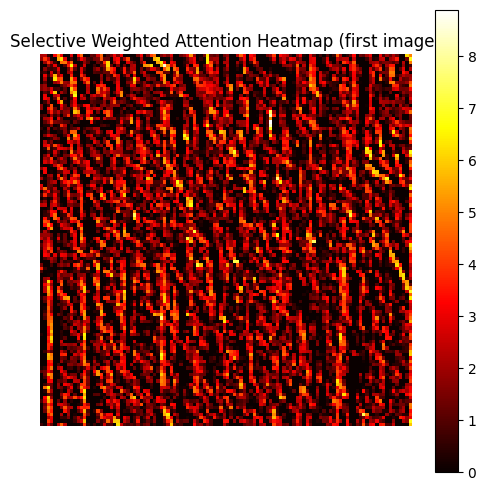

In [5]:
plt.figure(figsize=(6,6))
plt.imshow(f1[0,0].detach().cpu().numpy(), cmap='hot')
plt.colorbar()
plt.title('Selective Weighted Attention Heatmap (first image)')
plt.axis('off')


# feature map 2

(-0.5, 55.5, 55.5, -0.5)

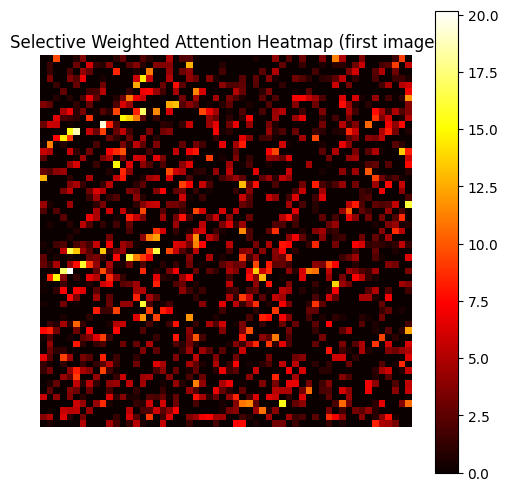

In [6]:
plt.figure(figsize=(6,6))
plt.imshow(f2[0,0].detach().cpu().numpy(), cmap='hot')
plt.colorbar()
plt.title('Selective Weighted Attention Heatmap (first image)')
plt.axis('off')


# test SPG


In [7]:
spug = spg.SelectiveWeightedAttention(in_channels1=64, in_channels2=128)

torch.Size([1, 32, 112, 112])


(-0.5, 111.5, 111.5, -0.5)

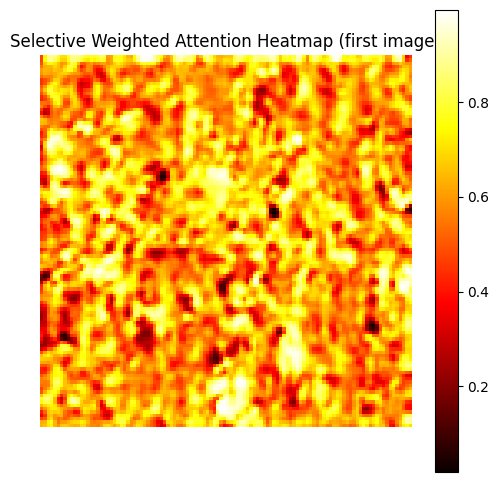

In [8]:
spog = spug(f1, f2) # the output of spg
print(spog.shape)

plt.figure(figsize=(6,6))
plt.imshow(spog[0,0].detach().cpu().numpy(), cmap='hot')
plt.colorbar()
plt.title('Selective Weighted Attention Heatmap (first image)')
plt.axis('off')

# test prm

## frist we convolce the f3

In [9]:
import danial.f3 as conv_f3

In [10]:
out = conv_f3.F3Conv(in_channels=256, out_channels=128)(f3)
print(f3.shape)
print(out.shape)

torch.Size([1, 256, 28, 28])
torch.Size([1, 128, 28, 28])


## visualise?

(-0.5, 27.5, 27.5, -0.5)

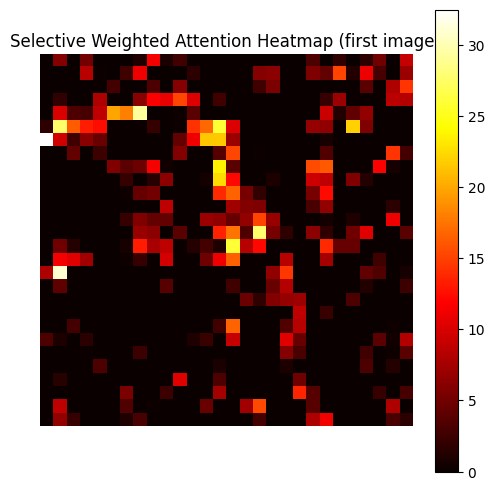

In [11]:
plt.figure(figsize=(6,6))
plt.imshow(f3[0,0].detach().cpu().numpy(), cmap='hot')
plt.colorbar()
plt.title('Selective Weighted Attention Heatmap (first image)')
plt.axis('off')

(-0.5, 27.5, 27.5, -0.5)

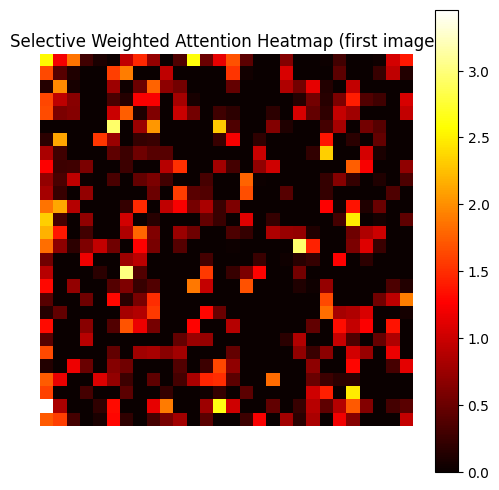

In [12]:
plt.figure(figsize=(6,6))
plt.imshow(out[0,0].detach().cpu().numpy(), cmap='hot')
plt.colorbar()
plt.title('Selective Weighted Attention Heatmap (first image)')
plt.axis('off')

## the prm

In [13]:
model = perm.PRM(f3_channels=128, spg_channels=32, fused_channels=128)


In [14]:
prm_out = model(out, spog) # output of prm
print(prm_out.shape)

torch.Size([1, 1, 64, 56, 56])


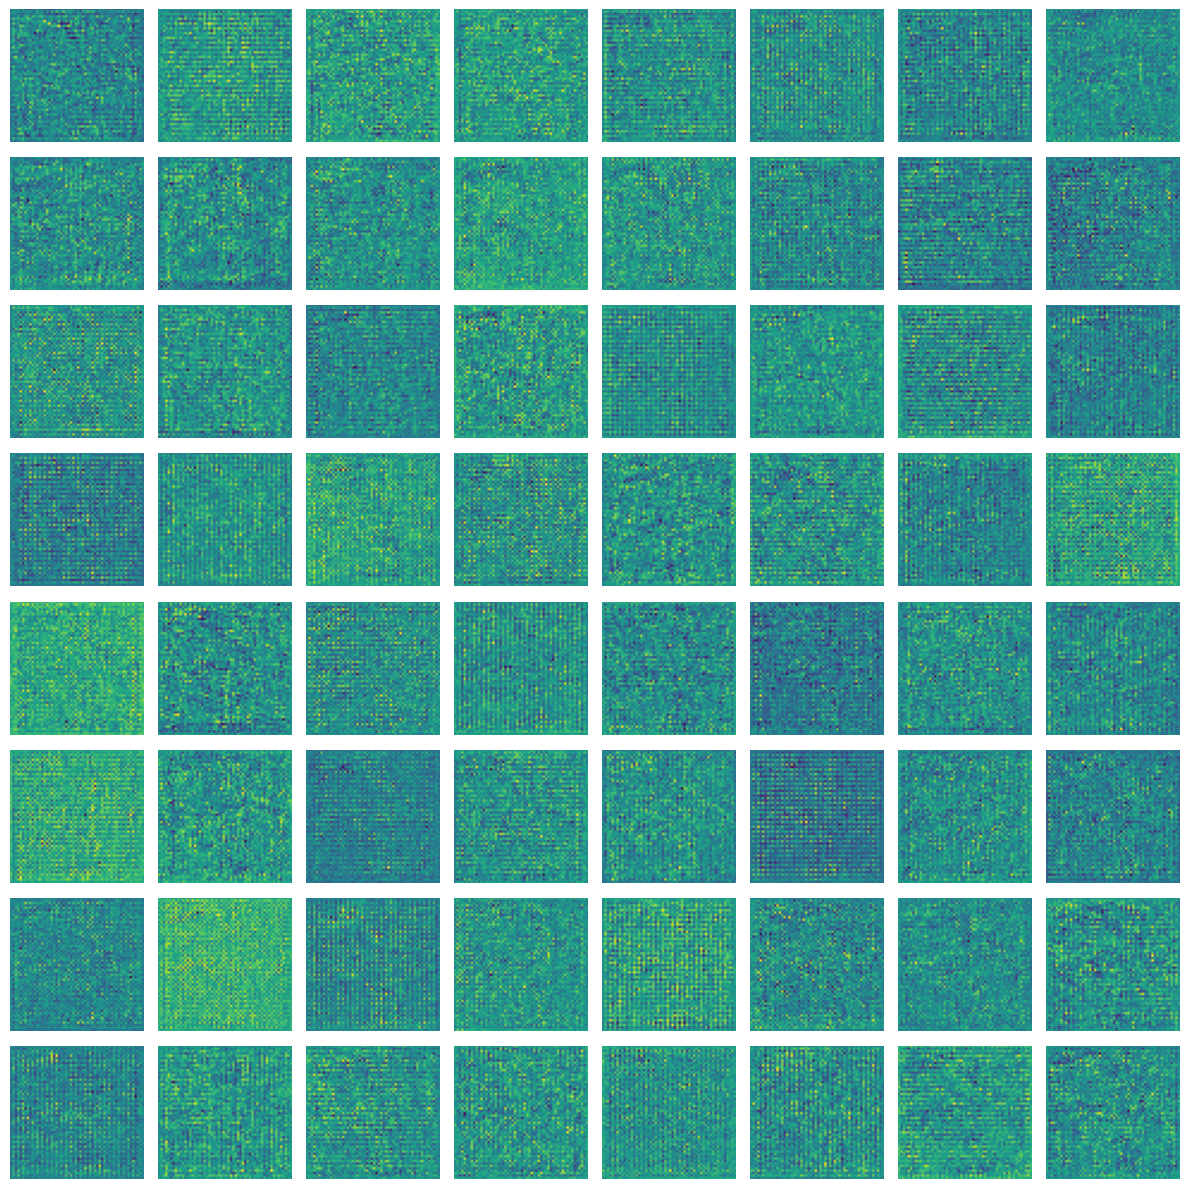

In [15]:
import torch
import matplotlib.pyplot as plt

# example PRM output
# caps_out = torch.randn(1, 1, 64, 56, 56)  # [B, 1, 64, H, W]
caps_out = prm_out[0, 0]  # remove batch and capsule channel → shape [64, 56, 56]

# Plot a grid of feature maps
num_maps = caps_out.shape[0]  # 64
rows, cols = 8, 8  # 8x8 grid

fig, axes = plt.subplots(rows, cols, figsize=(12,12))
for i in range(rows):
    for j in range(cols):
        idx = i * cols + j
        axes[i, j].imshow(caps_out[idx].detach().cpu(), cmap='viridis')
        axes[i, j].axis('off')
plt.tight_layout()
plt.show()


# lastly the fcs

In [16]:
print(out.shape)
print(prm_out.shape)

torch.Size([1, 128, 28, 28])
torch.Size([1, 1, 64, 56, 56])


## First we apply pre fcs things
1. convolute f3,
2. add with prm out
4. attention mechanism
5. rpn
6. roi

In [17]:
from danial import pre_fcs as pompom

ROI output shape: torch.Size([1, 64, 7, 7])
Saved branch shape: torch.Size([1, 64, 56, 56])


In [18]:
pre_fc = pompom.PreFCS()
roi_out = pre_fc(out, prm_out)

In [19]:
print("ROI output shape:", roi_out.shape)
print("Saved branch shape:", pre_fc.branch.shape)

ROI output shape: torch.Size([1, 64, 7, 7])
Saved branch shape: torch.Size([1, 64, 56, 56])


(-0.5, 6.5, 6.5, -0.5)

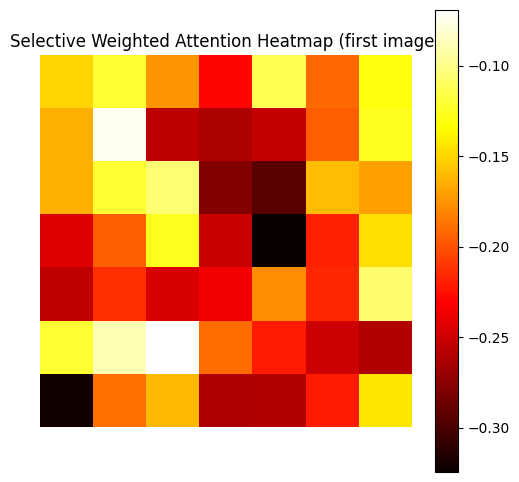

In [20]:
plt.figure(figsize=(6,6))
plt.imshow(roi_out[0,0].detach().cpu().numpy(), cmap='hot')
plt.colorbar()
plt.title('Selective Weighted Attention Heatmap (first image)')
plt.axis('off')

(-0.5, 55.5, 55.5, -0.5)

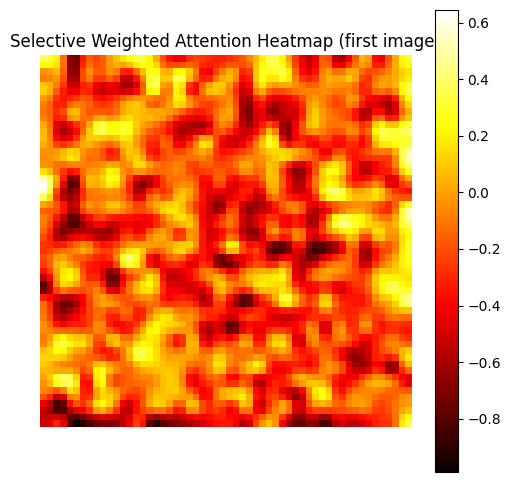

In [21]:
plt.figure(figsize=(6,6))
plt.imshow(pre_fc.branch[0,0].detach().cpu().numpy(), cmap='hot')
plt.colorbar()
plt.title('Selective Weighted Attention Heatmap (first image)')
plt.axis('off')

In [22]:
from danial import fcs as pompoms

In [23]:
crfcs = pompoms.CRFCS(roi_channels=64, boundary_channels=64)

In [24]:
print("ROI output shape:", roi_out.shape)
print("Saved branch shape:", pre_fc.branch.shape)

recovered = crfcs(roi_out, pre_fc.branch)

ROI output shape: torch.Size([1, 64, 7, 7])
Saved branch shape: torch.Size([1, 64, 56, 56])


In [29]:
print(recovered[0])
print(recovered[1])
print(recovered[2].shape)

tensor([[ 0.0234,  0.0694,  0.0050, -0.0138, -0.0007]],
       grad_fn=<AddmmBackward0>)
tensor([[-0.0239, -0.0236,  0.0666,  0.0449]], grad_fn=<AddmmBackward0>)
torch.Size([1, 64, 7, 7])


(-0.5, 6.5, 6.5, -0.5)

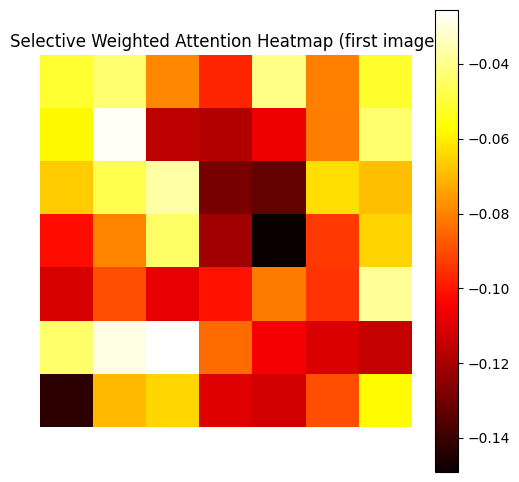

In [27]:
plt.figure(figsize=(6,6))
plt.imshow(recovered[2][0,0].detach().cpu().numpy(), cmap='hot')
plt.colorbar()
plt.title('Selective Weighted Attention Heatmap (first image)')
plt.axis('off')

In [15]:
from danial.model import Model

ImportError: cannot import name 'Model' from 'danial.model' (/Users/dania/code/fyp/MHNet/danial/model.py)

In [13]:
mod = model.Model()
binary_pred, boundary_pred, fused_feat = mod(test)

AttributeError: module 'danial.model' has no attribute 'Model'